Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: Apache-2.0

# Ask the Graph
# Notebook 2: Ingest Structured and Unstructured Data: Neptune and OpenSearch

In this notebook we ingest into the knowledge graph on Amazon Neptune and a search index/vector store on an Amazon OpenSearch Service domain. We ingest data prepared in notebooks 0 and 1. You do NOT need to run notebooks 0 and 1. We have prepared the data for you. It is available here: 

- s3://aws-neptune-customer-samples/tmls2024/source/ - source rdf files to load to Neptune
- s3://aws-neptune-customer-samples/tmls2024/aos/ - Chunk embeddings to load to OpenSearch
- s3://aws-neptune-customer-samples/tmls2024/graphdata/ - RDF files to load to Neptune
- s3://aws-neptune-customer-samples/tmls2024/documents/ - Press release documents as text files.
- s3://aws-neptune-customer-samples/tmls2024/chunks/ - Chunks of press release documents as text files.
- s3://aws-neptune-customer-samples/tmls2024/nadata/ - RDF files in ntriples form to load to Neptune Analytics (optional)

Here is our data model. This notebook prepares the unstructured sources (red boxes, upper third) and extracted facts (yellow boxes, middle third).

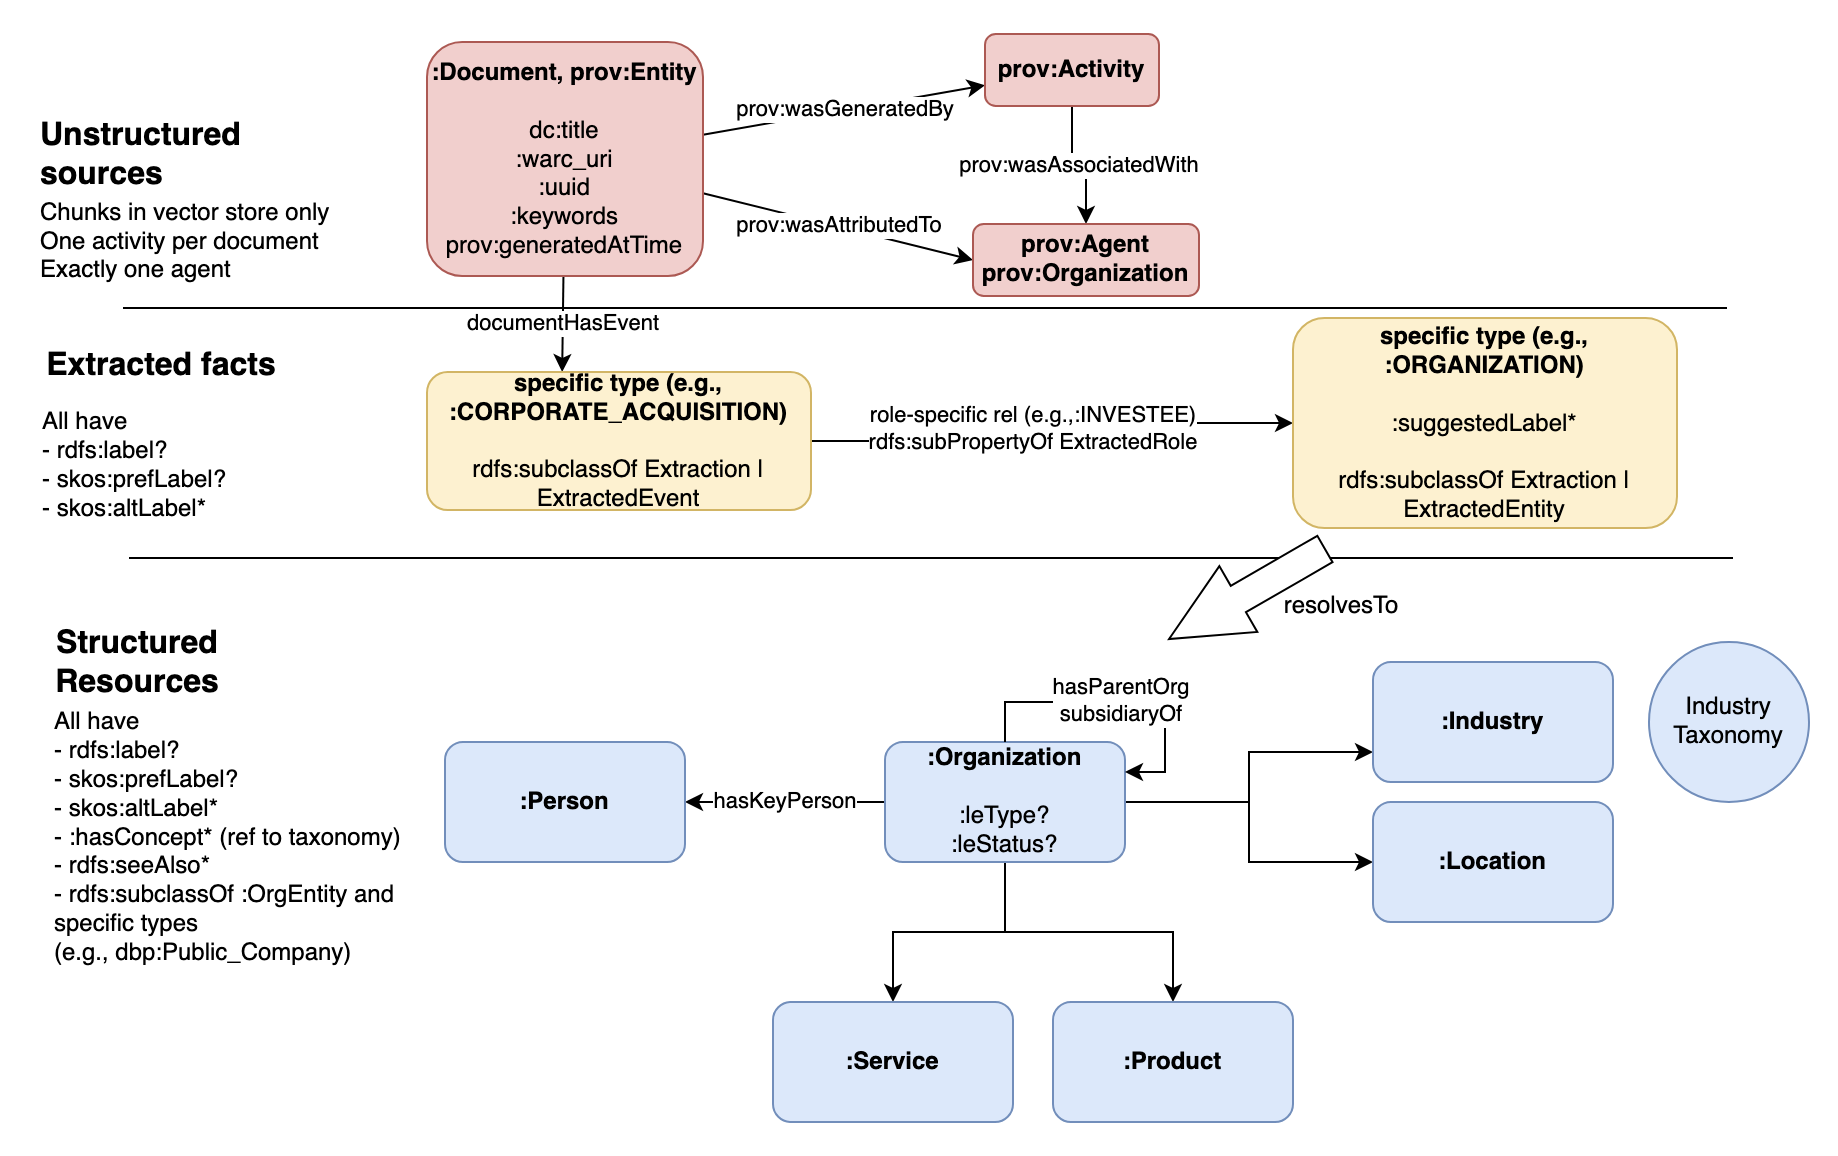

The next diagram shows data ingest:

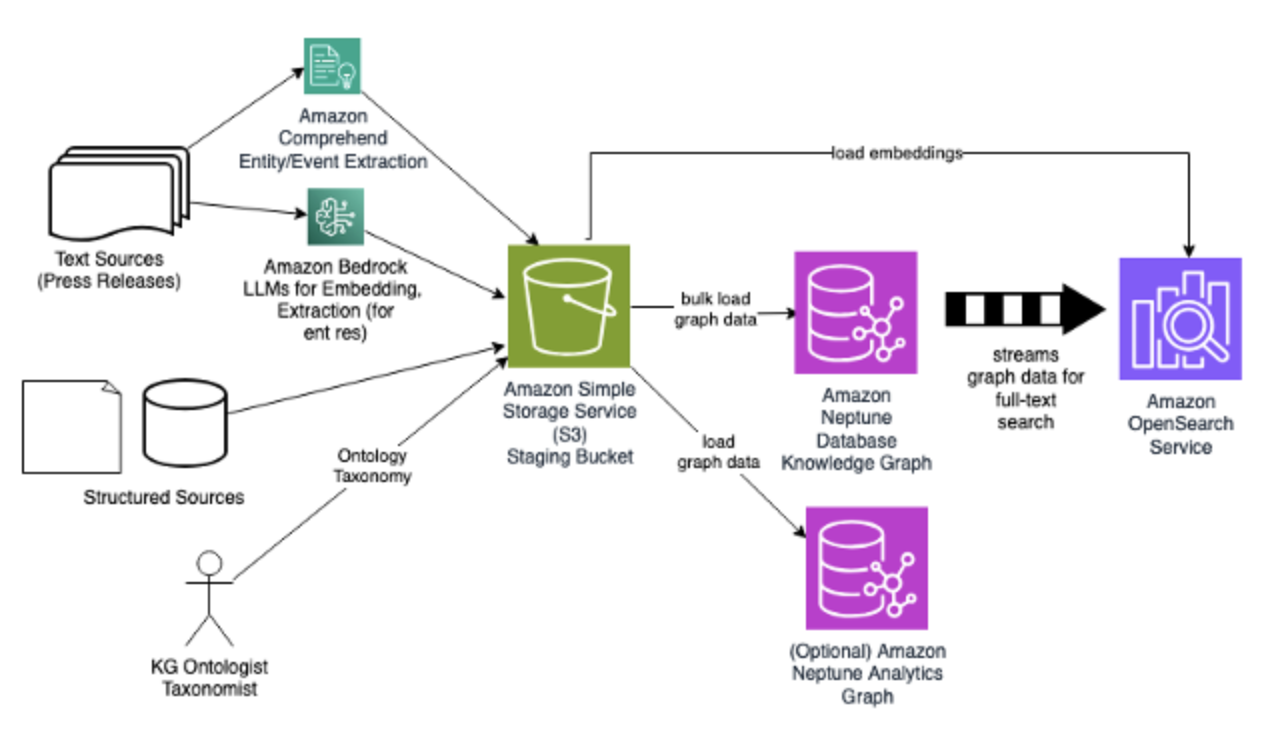

We assume you have a Neptune cluster, an OpenSearch Service domain, an S3 staging bucket, full-text search setup to stream Neptune updates to OpenSearch. Additionally, the notebook instance must have S3, Bedrock, Neptune, and OpenSearch permissions, as well as connectivity to Neptune and OpenSearch. Refer to the README for setup instructions.

## Install a few dependencies


In [ ]:
!pip install -q opensearch-py

In [ ]:
!pip install python-dotenv

## Get source data

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples/tmls2024/aos/ aos

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples/tmls2024/graphdata graphdata

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples/tmls2024/source source

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples/tmls2024/nadata nadata

## Initialize

In [ ]:
import os
import aos_helpers as aosh
from dotenv import load_dotenv

load_dotenv()

AOS_ENDPOINT_HOST=os.getenv("AOS_ENDPOINT_HOST")
aos_client=aosh.connect_aos(AOS_ENDPOINT_HOST)


## Load Chunk index to opensearch

In [ ]:
# Uncomment to delete the indexes (if you need to recreate them)
#aosh.delete_index(aos_client, aosh.CHUNK_INDEX)
#aosh.delete_index(aos_client, aosh.CHUNK_EMBEDDINGS_INDEX)


In [ ]:
aosh.create_index(aos_client, aosh.CHUNK_INDEX, aosh.CHUNKS_INDEX_DEF)
aosh.create_index(aos_client, aosh.CHUNK_EMBEDDINGS_INDEX, aosh.CHUNK_EMBEDDINGS_INDEX_DEF)


In [ ]:
cret=aosh.load_records_from_file(aos_client, "aos/chunks.jsonl", aosh.CHUNK_INDEX)

In [ ]:
eret=aosh.load_records_from_file(aos_client, "aos/chunk_embeddings.jsonl", aosh.CHUNK_EMBEDDINGS_INDEX)

In [ ]:
import json
with open('cret.json', 'w') as saved: 
    saved.write(json.dumps(cret))
with open('eret.json', 'w') as saved: 
    saved.write(json.dumps(eret))

In [ ]:
aosh.get_index(aos_client, aosh.CHUNK_INDEX)

### Verify with queries

In [ ]:
search_text="Whole foods"
query = {
    "query": {
        "match": {
            "chunk_content": { 
                "query": search_text,
                "fuzziness": "AUTO"
            }
        }
    }
}
ret=aos_client.search(index=aosh.CHUNK_INDEX, body=query)
for h in ret['hits']['hits']:
    print(f"\n\t{h['_id']}|{h['_score']}|{h['_source']['title']}|{h['_source']['chunk_content']}")


In [ ]:
import ai_helpers as aih

search_vector=aih.make_embedding("Amazon buys Ring or Rivian")

query={
    "query": {
        "knn": {
            "embedding":{
                "vector":search_vector,
                "k":30
            }
        }
    }
}

ret=aos_client.search(index=aosh.CHUNK_EMBEDDINGS_INDEX, body=query)
for h in ret['hits']['hits']:
    print(f"\n\t{h['_id']}|{h['_score']}|{h['_source']['title']}|{h['_source']['chunk_content']}")


## Load Neptune data
### Copy to an S3 bucket in your account in the same region


In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()
S3_BUCKET_NOSLASH=os.getenv("S3_BUCKET_NOSLASH")
S3_BUCKET_NOSLASH


In [ ]:
%%bash -s "$S3_BUCKET_NOSLASH"

aws s3 sync graphdata/rdf $1/ndb
aws s3 sync source/rdf $1/ndb
aws s3 sync nadata/ $1/na
aws s3 rm --recursive $1/ndb/.ipynb_checkpoints
aws s3 rm --recursive $1/na/.ipynb_checkpoints

### Bulk-load to Neptune

We assume you are using a notebook instance configured to point to your Neptune cluster. If that's not the case, set the graph notebook config as follows:

```
%%graph_notebook_config
{
  "host": "your-neptune-endpoint",
  "neptune_service": "neptune-db",
  "port": 8182,
  "auth_mode": "DEFAULT or IAM",
  "load_from_s3_arn": "your-s3-load-role",
  "ssl": true,
  "ssl_verify": true,
  "aws_region": "your-neptune-region"
}
```

In [ ]:
%load -s {S3_BUCKET_NOSLASH}/ndb -f turtle -p OVERSUBSCRIBE --store-to result1 --no-fail-on-error --run

In [ ]:
%load_status {result1['payload']['loadId']} --details --errors

### Verify with queries
#### Find organizational entities

In [ ]:
%%sparql

PREFIX ns1: <http://example.org/orgdemo/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

select * where {
    ?s rdf:type/rdfs:subClassOf ns1:OrgEntity .
    ?s a ?t .
} LIMIT 100


#### Find attributes of Amazon structured entity

In [ ]:
%%sparql 
PREFIX : <http://example.org/orgdemo/> 

SELECT ?s ?p ?o WHERE {
    ?s rdf:type/rdfs:subClassOf* :OrgEntity .
    BIND (<http://dbpedia.org/resource/Amazon_(company)> as ?s ).
    ?s ?p ?o
}
LIMIT 100

#### Link documents to extracted events to extracted entities to blue/structured resources

In [ ]:
%%sparql

PREFIX : <http://example.org/orgdemo/> 
PREFIX ev: <http://example.org/orgdemo/xev> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

select * where {
    ?ent :resolvesTo ?blue .
    ?blue rdf:type/rdfs:subClassOf :OrgEntity .
    ?doc :documentHasEvent ?ev .
    ?role rdfs:subPropertyOf :ExtractedRole .
    ?ev ?role ?ent .
} 
ORDER BY ?blue ?doc ?ev
LIMIT 100


### Verify FTS results in OpenSearch
Neptune syncs its data with your OpenSearch Service domain in an index called amazon_neptune.
Check that there is content in that index.

In [ ]:
aosh.get_index(aos_client, "amazon_neptune")

In [ ]:
search_text="amazon_(company)"
query = {
    "size": 40,
    "query": {
        "match_all": {}
    }
}
ret=aos_client.search(index="amazon_neptune", body=query)
ret

In [ ]:
aosh.find_entities_by_label(aos_client, ["amazon.com"])

## Optional: Load to Neptune Analytics
If using variable-length path or graph algorithms on the graph data, load the RDF data to your Neptune Analytics graph.
### We assume this notebook is configured to use a Neptune database cluster. So setup connection to the graph using the next cell:

In [ ]:
%%graph_notebook_config
{
  "host": "your-neptune-endpoint",
  "neptune_service": "neptune-graph",
  "port": 443,
  "auth_mode": "IAM",
  "ssl": true,
  "ssl_verify": true,
  "aws_region": "your-neptune-region"
}


### Run the load (openCypher)

In [ ]:
%%oc

CALL neptune.load(
  {
    source: f"{S3_BUCKET_NOSLASH}/na",
    region: "your-neptune-region",
    format: "ntriples",
    failOnError: false,
    concurrency: 1,
    blankNodeHandling: "convertToIri"
             
  }
)


### Verify with openCypher queries
#### Breadth-first search from Amazon

In [ ]:
%%oc

MATCH(n) 
WHERE 
id(n)='<http://dbpedia.org/resource/Amazon_(company)>'
CALL neptune.algo.bfs.parents(n, 
  {
    maxDepth: 5,
    traversalDirection: 'both'
  }
)
YIELD source, node, parent
WHERE id(node)='<http://dbpedia.org/resource/Whole_Foods_Market>'
RETURN id(source), id(node), id(parent)
LIMIT 100

#### Variable-length path

In [ ]:
%%oc 

MATCH path=(a)-[*0..5]-(b)
WHERE id(a)='<http://example.org/industry/BigTech>'
and id(b)='<http://dbpedia.org/resource/James_D._Taiclet>'
RETURN path
LIMIT 100